### 1) ICA

1. Étudier le script ica_audio.py et l’utiliser pour générer le mélange stéréo. Prendre le
temps d’écouter les différents signaux.

In [10]:
# ica_audio.py
# Author: Slim Essid
import pylab as pl
import numpy as np
import wave
from sklearn import decomposition

# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    wf = wave.open(filename)
    s = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s

def wavwrite(filename, s, nchannels=1):
    wf = wave.open(filename,'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()
    
s1 = wavread('snd/es02.wav')
s2 = wavread('snd/si01.wav')

# -- Create stereo mix ---------------------------------------------------------
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([ [0.6, 0.5],[0.4, 0.5]])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('snd/mix.wav', x, nchannels=2)

2. Utiliser l’ICA pour extraire les sources originales à partir du mélange. On exploitera pour
cela sklearn.decomposition.FastICA.

In [13]:
from scipy.io import wavfile as wav
from sklearn.decomposition import FastICA

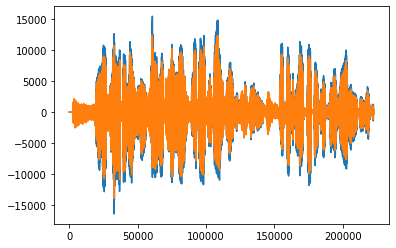

In [11]:
rate, data = wav.read('snd/mix.wav')
plt.plot(data)
plt.show()

In [14]:
transformer = FastICA(n_components=2,random_state=0)
X_transformed = transformer.fit_transform(data)

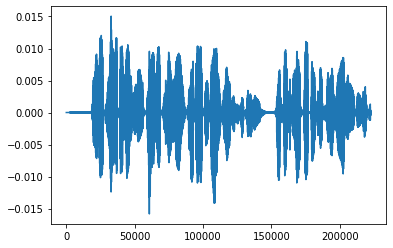

In [15]:
plt.plot(X_transformed[:,0])

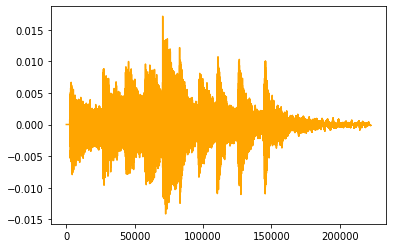

In [16]:
plt.plot(X_transformed[:,1], c='orange')

3. Créer les fichiers audio pour chaque source extraite et les écouter.

In [18]:
wavwrite('snd/mix_1.wav', X_transformed[:,0])
wavwrite('snd/mix_2.wav', X_transformed[:,1])

### 2) PCA et NMF

1. Étudier et tester le script pca_nmf_faces.py. Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA.

Dataset consists of 400 faces
2061 negative-valued pixels
2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels
Extracting the top 10 Eigenfaces - PCA...
done in 0.063s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2220 negative-valued pixels
2127 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 11.322s


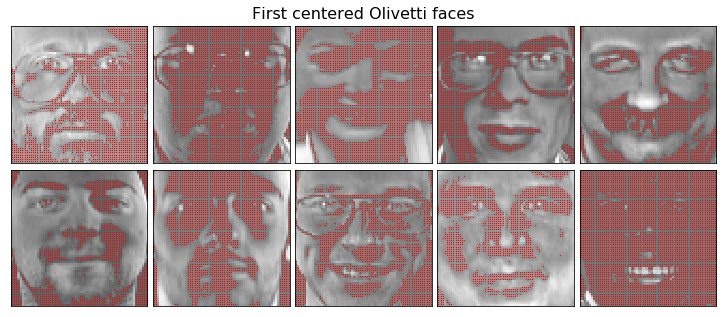

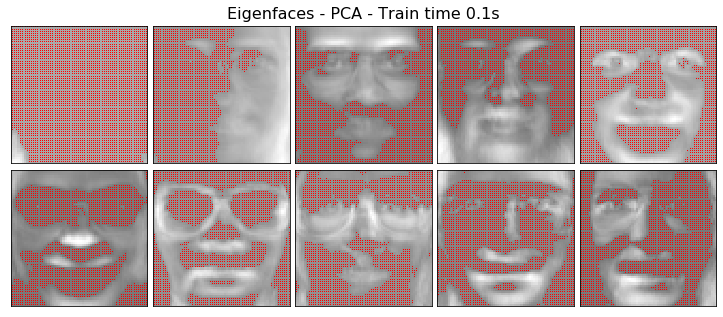

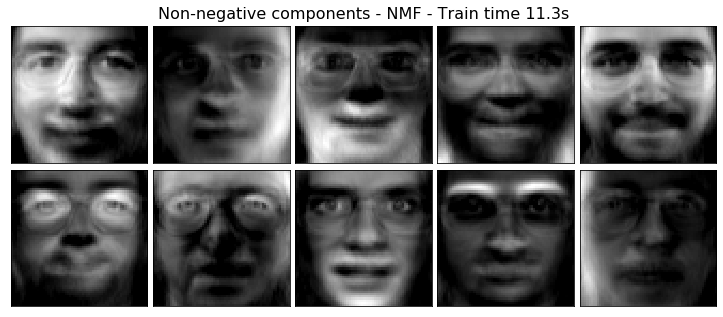

In [38]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD

from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition

# -- Prepare data and define utility functions ---------------------------------
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

faces = dataset.data
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print ("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        #print "vmax: %f, vmin: %f" % (vmax, vmin)
        #print comp
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')
            print (len(dmy[0]), "negative-valued pixels")
        pl.xticks(())
        pl.yticks(())
    
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods ----------------------------------------------------

# List of the different estimators and whether to center the data
estimators = [('pca', 'Eigenfaces - PCA', decomposition.PCA(n_components=n_components, whiten=True),True),
              ('nmf', 'Non-negative components - NMF', 
               decomposition.NMF(n_components=n_components, init=None, tol=1e-6,max_iter=2000),False)]

# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered
for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print ("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = X
    if center:
        data = X_
    data = estimator.fit_transform(data)
    train_time = (time() - t0)
    print ("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery('%s - Train time %.1fs' % (name, train_time),components_[:n_components])

2. Modifier le script pour réaliser une évaluation des performances d’un système de recon-
naissance automatique de visages utilisant les caractéristiques extraites par PCA, compa-
rées à celles obtenues par un système exploitant les caractéristiques extraites par NMF.
On pourra utiliser la LDA pour la classification. On effectuera l’évaluation par validation
croisée. On observera l’évolution des scores en faisant varier le nombre de composantes
utilisé dans les décompositions.